# Preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix  # LightFM fit method requires coo matrix format as input.

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from sklearn.metrics import roc_auc_score
from lightfm.data import Dataset

/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


### Data Import and Cleaning - Events

In [2]:
# Importing Events data and sorting by timestamp column which corresponds the historical order of events.

df_events = pd.read_csv("events.csv")
df_events = df_events.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [3]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,addtocart,297662,NaN
1,1430622011289,829044,view,60987,NaN
2,1430622013048,652699,view,252860,NaN
3,1430622024154,1125936,view,33661,NaN
4,1430622026228,693516,view,297662,NaN


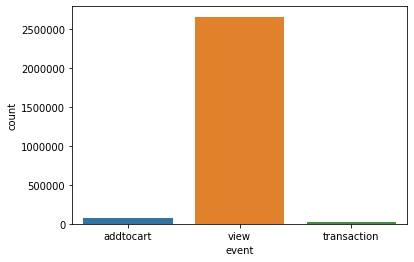

In [4]:
# View on the ratio between different types of events.
sns.countplot(x='event', data=df_events)

In [5]:
df_events.event.unique()

array(['addtocart', 'view', 'transaction'], dtype=object)

In [6]:
# Events types “view”, “addtocart”, “transaction” are the implicit customer feedback.
# They can be considered as rating and will be transformed from categorical to numerical format.

# The weights are subject to tuning together with hyperparameters to achieve better performance.
# Initial weights: view=1, add to cart=2, purchase=3.

weight_view = 1
weight_addtocart = 2
weight_transaction = 3

df_events.event.replace(to_replace=dict(
    view=weight_view, addtocart=weight_addtocart, transaction=weight_transaction), inplace=True)

In [7]:
# Now the events replaced with corresponding weights.
df_events.event.unique()

array([2, 1, 3])

In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            int64
itemid           int64
transactionid    float64
dtypes: float64(1), int64(4)
memory usage: 105.1 MB


In [9]:
# Check sparsity level of interactions matrix for the whole dataset.
# Collaborative filtering acceptable sparsity should be lower than 99.5%

# Create iterations sparse matrix
row = df_events['visitorid'].astype(int)
col = df_events['itemid'].astype(int)
data = df_events['event'].astype(int)
interactions_grid = coo_matrix((data, (row, col)), shape=None)


# Check the current matrix sparsity.
size = interactions_grid.shape[0]*interactions_grid.shape[1]
values = len(interactions_grid.nonzero()[0])
sparsity = 100 - values/size
print('Sparsity level: ', sparsity, ' %')

Sparsity level:  99.99999580600476  %


In [10]:
# Since the sparsity level is too high for performing collaborative filtering, there's a need in data cleaning.
# For this purpose visitor and item activity needs to be reviewed to remove the noise.

# Firstly, need to understand the occurency of each user in the events dataframe.
visitor_occurencies = df_events['visitorid'].value_counts().rename_axis('visitorid').reset_index(name='occurencies')

In [11]:
visitor_occurencies

,visitorid,occurencies
0,1150086,7757
1,530559,4328
2,152963,3024
3,895999,2474
4,163561,2410
...,...,...
1407575,1027348,1
1407576,1021203,1
1407577,1023250,1
1407578,1017105,1


In [39]:
# Drop the rows with USERS having only one occurance.
df_events_cleaned = df_events.groupby('visitorid').filter(lambda x : len(x)>1).reset_index(drop=True)

In [35]:
df_events_cleaned

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,2,297662,NaN
1,1430622026228,693516,1,297662,NaN
2,1430622029427,693516,2,297662,NaN
3,1430622033686,181106,1,278445,NaN
4,1430622040988,1399056,1,197200,NaN
...,...,...,...,...,...
1703223,1442545090353,1233986,1,277762,NaN
1703224,1442545116506,1162044,1,371573,NaN
1703225,1442545138914,1265892,1,102605,NaN
1703226,1442545151261,1249751,1,404734,NaN


In [36]:
print('Cleaned set ratio to original set: ',round(len(df_events_cleaned)/len(df_events)*100,2), '%')

Cleaned set ratio to original set:  61.8 %


In [38]:
# Check sparsity level of interactions matrix for the CLEANED dataset.
# Collaborative filtering acceptable sparsity should be lower than 99.5%

# Create iterations sparse matrix
row = df_events_cleaned['visitorid'].astype(int)
col = df_events_cleaned['itemid'].astype(int)
data = df_events_cleaned['event'].astype(int)
interactions_grid = coo_matrix((data, (row, col)), shape=None)


# Check the current matrix sparsity.
size = interactions_grid.shape[0]*interactions_grid.shape[1]
values = len(interactions_grid.nonzero()[0])
sparsity = 100 - values/size
print('Sparsity level: ', sparsity, ' %')

Sparsity level:  99.99999740816443  %


### Data Import and Cleaning - Categories

In [15]:
# Import Categories data

df_categories = pd.read_csv("category_tree.csv")
df_categories.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [16]:
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
categoryid    1669 non-null int64
parentid      1644 non-null float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


### Data Import and Cleaning - Properties

In [17]:
# Import Properties ### Data Import and Cleaning - Eventsdata

df_properties1 = pd.DataFrame(pd.read_csv("item_properties_part1.csv"))
df_properties2 = pd.DataFrame(pd.read_csv("item_properties_part2.csv"))
df_properties = pd.concat([df_properties1, df_properties2])

# data to be sorted by timestamp to reflect the historical change log.
df_properties = df_properties.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

df_properties.head(10)

,timestamp,itemid,property,value
0,1431226800000,317951,790,n32880.000
1,1431226800000,422842,480,1133979
2,1431226800000,310185,776,103591
3,1431226800000,110973,112,679677
4,1431226800000,179597,available,0
5,1431226800000,260136,available,1
6,1431226800000,138592,764,1285872
7,1431226800000,216269,364,336749
8,1431226800000,299944,764,1285872
9,1431226800000,146103,112,679677


In [18]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


### Train / Test split

In [19]:
# Use timestamps for split which mimics the real-life case as the events are sorted in historical order.
# Split ratio is 80% for train set, and 20% for test set.

split_point = int(np.ceil(len(df_events_cleaned)*0.8))  # Index of split point.
split_point_time = int(df_events_cleaned.loc[split_point]['timestamp'])  # Timestamp of split point.

df_events_train = df_events_cleaned.loc[0:split_point]
df_events_test = df_events_cleaned.loc[split_point+1:]

In [20]:
df_events_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403634 entries, 0 to 1403633
Data columns (total 5 columns):
timestamp        1403634 non-null int64
visitorid        1403634 non-null int64
event            1403634 non-null int64
itemid           1403634 non-null int64
transactionid    17626 non-null float64
dtypes: float64(1), int64(4)
memory usage: 53.5 MB


In [21]:
df_events_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350907 entries, 1403634 to 1754540
Data columns (total 5 columns):
timestamp        350907 non-null int64
visitorid        350907 non-null int64
event            350907 non-null int64
itemid           350907 non-null int64
transactionid    4761 non-null float64
dtypes: float64(1), int64(4)
memory usage: 13.4 MB


### Interaction matrices

In [22]:
# Train set. Create sparse matrix of visitor-item iterations.
# The events are coded as numbers reflecting the level of implicit feedback (the higher the better).\
# For the interaction matrix the highest feedback will be used.

df_events_train = df_events_train.sort_values('event').drop_duplicates(
    subset=['visitorid', 'itemid'], 
    keep='last').sort_values('timestamp').reset_index(drop=True)

In [23]:
df_events_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915866 entries, 0 to 915865
Data columns (total 5 columns):
timestamp        915866 non-null int64
visitorid        915866 non-null int64
event            915866 non-null int64
itemid           915866 non-null int64
transactionid    16702 non-null float64
dtypes: float64(1), int64(4)
memory usage: 34.9 MB


In [24]:
# Create a sparse matrix for Train set interactions.

row = df_events_train['visitorid'].astype(int)
col = df_events_train['itemid'].astype(int)
data = df_events_train['event'].astype(int)
interactions_grid_train = coo_matrix((data, (row, col)), shape=None)

In [25]:
interactions_grid_train

<1407574x466868 sparse matrix of type '<class 'numpy.int64'>'
	with 915866 stored elements in COOrdinate format>

In [26]:
# Collaborative filtering maximum sparsity can be around 99.5%
# Check the current matrix sparsity.

size = interactions_grid_train.shape[0]*interactions_grid_train.shape[1]
values = len(interactions_grid_train.nonzero()[0])
sparsity = 100*(1 - (values/size))
print('Sparsity level: ', sparsity, ' %')

Sparsity level:  99.99986063086868  %


In [27]:
print("Coo matrix size: ", interactions_grid_train.data.nbytes/1000000, ' Megabytes')

Coo matrix size:  7.326928  Megabytes


In [28]:
# Test set. Same approach.

df_events_test = df_events_test.sort_values('event').drop_duplicates(
    subset=['visitorid', 'itemid'], 
    keep='last').sort_values('timestamp').reset_index(drop=True)

#create a sparse matrix
row = df_events_test['visitorid'].astype(int)
col = df_events_test['itemid'].astype(int)
data = df_events_test['event'].astype(int)
interactions_grid_test = coo_matrix((data, (row, col)), shape=None)

In [29]:
df_events_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233898 entries, 0 to 233897
Data columns (total 5 columns):
timestamp        233898 non-null int64
visitorid        233898 non-null int64
event            233898 non-null int64
itemid           233898 non-null int64
transactionid    4540 non-null float64
dtypes: float64(1), int64(4)
memory usage: 8.9 MB


In [30]:
interactions_grid_test

<1407529x466865 sparse matrix of type '<class 'numpy.int64'>'
	with 233898 stored elements in COOrdinate format>

In [31]:
size = interactions_grid_test.shape[0]*interactions_grid_test.shape[1]
values = len(interactions_grid_test.nonzero()[0])
sparsity = 100*(1 - (values/size))
print('Sparsity level: ', sparsity, ' %')

Sparsity level:  99.99996440591447  %


In [ ]:
print("Coo matrix size: ", interactions_grid_test.data.nbytes/1000000, ' Megabytes')

# LightFM model training (no item_features)

In [ ]:
# Building model without item features first. This will mean collaboration based predictions.

start_time = time.time()

model = LightFM(no_components=50, loss='warp')
model.fit(interactions_grid_train, epochs=20, num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

In [ ]:
start_time = time.time()
# train_auc = auc_score(model, interactions_grid_train).mean()
train_auc = auc_score(model = model,
                      test_interactions = None,
                      train_interactions = interactions_grid_train,
                      user_features=None,
                      item_features=None,
                      preserve_rows=False,
                      num_threads=4,
                      check_intersections=True
                     ).mean()
print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

In [ ]:
start_time = time.time()
test_auc = auc_score(model, interactions_grid_test).mean()
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

In [ ]:
start_time = time.time()
train_precision = precision_at_k(model, interactions_grid_train, k=10).mean()
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

In [ ]:
start_time = time.time()
test_precision = precision_at_k(model, interactions_grid_test, k=10).mean()
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

# LightFM model training (with item_features)

In [ ]:
### Item properties matrix

In [ ]:
df_properties.info()

In [ ]:
# Item properties are historical log of changes. No way to feed timestamps to model.
# Need to simplify, so the latest property value will be used for each item.

df_properties_short = df_properties.sort_values('timestamp').drop_duplicates(
    subset=['itemid', 'property' ], 
    keep='last').reset_index(drop=True)

df_properties_short.info()

In [ ]:
# The item_features matrix is to be used for training.
# Therefore, rows within train/test split point timestamp are to be used.
df_properties_short = df_properties_short[df_properties_short.timestamp <= split_point_time]

df_properties_short.info()

In [ ]:
# The 'available' property is to be removed as it is critical for making purchase and changing over time.
df_properties_short = df_properties_short[df_properties_short.property != 'available']

# Code 'categoryid' property as number
df_properties_short = df_properties_short.loc[df_properties_short['property'] == 'categoryid', 'property'] = 2020

df_properties_short.info()

In [ ]:
df_properties_short

In [ ]:
# Drop timestamps column
df_properties_short.drop(['timestamp'], axis=1, inplace=True)
df_properties_short

In [ ]:
#create a sparse matrix
row = df_properties_short['itemid'].astype(int)
col = df_properties_short['property'].astype(int)
data = df_properties_short['value'].astype(str)
item_features_grid = csr_matrix((data, (row, col)), shape=None)